# Collation with decision graph

Revision based on consultation on 2021-01-01

w1 patterns are on top, w2 on left

Order the patterns (shared ngrams of any length) on:

1. Coordinate witness A ascending, then
1. Coordinate witness B ascending, then
1. Length of the pattern from large to small (descending).

Patterns have the shape (A:int, B:int, ngram:str)

The first part of this notebook, through the identification of shared ngrams, is copied from our earlier efforts.

## Data

In [1]:
# two witnesses, with repetition and transposition

w1 = """the red and the black cat"""
w2 = """the black and the red cat"""

## Construct list of ngrams shared by witnesses

Find ngrams and positions in witnesses

### Tokenize witnesses

In [2]:
def tokenize_witnesses(w1_string, w2_string):
    '''Return list of witnesses, each represented by a list of tokens'''
    # TODO: handle punctuation, upper- ~ lowercase
    w1_tokens = w1.split()
    w2_tokens = w2.split()
    witnesses = [w1_tokens, w2_tokens]
    return witnesses

In [3]:
witnesses = tokenize_witnesses(w1, w2)
print(witnesses) # take a look

[['the', 'red', 'and', 'the', 'black', 'cat'], ['the', 'black', 'and', 'the', 'red', 'cat']]


### Find ngrams shared by the witnesses

In [4]:
from collections import defaultdict

def compute_ngrams_all(witness):
    '''Create n-grams and returns offsets and lengths

    Argument:
    witness:list -- list of tokens in witness

    Returns:
    ngrams:dict --       key is ngram
                         value is list of start positions in witness for ngram
    token_counts:dict -- key is ngram
                         value is token count of ngram
    '''
    ngram_offsets = defaultdict(list)
    token_counts = {}
    for n in range(1, len(witness) + 1):
        for i in range(len(witness)-n+1):
            g = ' '.join(witness[i:i+n]) # store each ngram as g temporarily
            ngram_offsets[g].append(i)
            token_counts[g] = n
    return ngram_offsets, token_counts

In [5]:
ngram_offsets_by_witness_dict = {} # keyed by witness
ngram_lengths = {}
for index, witness in enumerate(witnesses):
    map1, map2 = compute_ngrams_all(witness)
    ngram_offsets_by_witness_dict['w' + str(index + 1)] = map1
    ngram_lengths.update(map2)

In [6]:
# Look at ngram lists for each witness
# Keys of inner dictionary are ngrams, values are lists of start positions in witness
for key in ngram_offsets_by_witness_dict.keys():
    print('Witness ' + key)
    print(ngram_offsets_by_witness_dict[key])
    print()

Witness w1
defaultdict(<class 'list'>, {'the': [0, 3], 'red': [1], 'and': [2], 'black': [4], 'cat': [5], 'the red': [0], 'red and': [1], 'and the': [2], 'the black': [3], 'black cat': [4], 'the red and': [0], 'red and the': [1], 'and the black': [2], 'the black cat': [3], 'the red and the': [0], 'red and the black': [1], 'and the black cat': [2], 'the red and the black': [0], 'red and the black cat': [1], 'the red and the black cat': [0]})

Witness w2
defaultdict(<class 'list'>, {'the': [0, 3], 'black': [1], 'and': [2], 'red': [4], 'cat': [5], 'the black': [0], 'black and': [1], 'and the': [2], 'the red': [3], 'red cat': [4], 'the black and': [0], 'black and the': [1], 'and the red': [2], 'the red cat': [3], 'the black and the': [0], 'black and the red': [1], 'and the red cat': [2], 'the black and the red': [0], 'black and the red cat': [1], 'the black and the red cat': [0]})



In [7]:
# Look at ngram lengths (combined)
print(ngram_lengths)

{'the': 1, 'red': 1, 'and': 1, 'black': 1, 'cat': 1, 'the red': 2, 'red and': 2, 'and the': 2, 'the black': 2, 'black cat': 2, 'the red and': 3, 'red and the': 3, 'and the black': 3, 'the black cat': 3, 'the red and the': 4, 'red and the black': 4, 'and the black cat': 4, 'the red and the black': 5, 'red and the black cat': 5, 'the red and the black cat': 6, 'black and': 2, 'red cat': 2, 'the black and': 3, 'black and the': 3, 'and the red': 3, 'the red cat': 3, 'the black and the': 4, 'black and the red': 4, 'and the red cat': 4, 'the black and the red': 5, 'black and the red cat': 5, 'the black and the red cat': 6}


In [8]:
# find keys shared by *all* witnesses
shared_ngrams = set(ngram_offsets_by_witness_dict["w1"].keys())
for value in ngram_offsets_by_witness_dict.values():
    shared_ngrams = shared_ngrams.intersection(value.keys())

shared_ngrams # take a look

{'and', 'and the', 'black', 'cat', 'red', 'the', 'the black', 'the red'}

### Use shared ngrams to find potential alignments

In [9]:
# output format: {ngram : [(0,1), (2,3)]}, where
#   the two entries in each tuple are for witnesses A and B
potential_alignments = defaultdict(list)
for ngram in shared_ngrams:
    for w1_offset in ngram_offsets_by_witness_dict['w1'][ngram]:
        for w2_offset in ngram_offsets_by_witness_dict['w2'][ngram]:
            potential_alignments[ngram].append((w1_offset, w2_offset))

print(potential_alignments)

defaultdict(<class 'list'>, {'the black': [(3, 0)], 'black': [(4, 1)], 'and the': [(2, 2)], 'red': [(1, 4)], 'and': [(2, 2)], 'the': [(0, 0), (0, 3), (3, 0), (3, 3)], 'cat': [(5, 5)], 'the red': [(0, 3)]})


### Invert keys and values for potential alignments

* Keys are now individual tuples of (A, B) start positions
* Values are now lists of ngrams of different lengths at those positions

In [10]:
alignments = defaultdict(list)
for key,value in potential_alignments.items():
    for t in value:
        alignments[t].append(key)

print(alignments)

defaultdict(<class 'list'>, {(3, 0): ['the black', 'the'], (4, 1): ['black'], (2, 2): ['and the', 'and'], (1, 4): ['red'], (0, 0): ['the'], (0, 3): ['the', 'the red'], (3, 3): ['the'], (5, 5): ['cat']})


## New content begins here: Create df

In [11]:
# column labels, ordered by w1 pos, then w2 pos, then ngram length (long to short)
labels_A = [] # will need to be sorted after all values have been added
for k, v in alignments.items():
    for ngram in v: # add tuple for each ngram at A,B positions
        labels_A.append((k[0], k[1], ngram))
labels_A = sorted(labels_A, key=lambda x: (x[0], x[1], -ngram_lengths[x[2]]))
labels_A.insert(0, (-1, -1, None))
labels_A # take a look

[(-1, -1, None),
 (0, 0, 'the'),
 (0, 3, 'the red'),
 (0, 3, 'the'),
 (1, 4, 'red'),
 (2, 2, 'and the'),
 (2, 2, 'and'),
 (3, 0, 'the black'),
 (3, 0, 'the'),
 (3, 3, 'the'),
 (4, 1, 'black'),
 (5, 5, 'cat')]

In [12]:
labels_B = sorted(labels_A[1:], key=lambda x: (x[1], x[0], -ngram_lengths[x[2]]))
labels_B.insert(0, (-1, -1, None))
labels_B # take a look

[(-1, -1, None),
 (0, 0, 'the'),
 (3, 0, 'the black'),
 (3, 0, 'the'),
 (4, 1, 'black'),
 (2, 2, 'and the'),
 (2, 2, 'and'),
 (0, 3, 'the red'),
 (0, 3, 'the'),
 (3, 3, 'the'),
 (1, 4, 'red'),
 (5, 5, 'cat')]

## Create df for patterns

Cell value is 1 if the ngrams in A and B are equal, otherwise 0

In [13]:
# create sparse matrix
import pandas as pd
import numpy as np
columns = sorted(list(set((A, ngram) for (A, B, ngram) in labels_A)), key=lambda x: (x[0], -ngram_lengths[x[1]] if x[1] in ngram_lengths.keys() else 0))
rows = []
new_row_labels = sorted(list(set((item[1], item[2], ngram_lengths[item[2]] if item[2] in ngram_lengths.keys() else 0) for item in labels_B)), key=lambda x: (x[0], -ngram_lengths[x[1]] if x[1] in ngram_lengths.keys() else 0))
for row_label in new_row_labels:
    row_cells = []
    for column_label in columns:
        row_cells.append(1 if row_label[1] == column_label[1] else 0)
    rows.append(row_cells)
index = pd.MultiIndex.from_tuples(new_row_labels, names=('B', 'ngram', 'ngram_length'))
df = pd.DataFrame(rows, index=index, columns=[A for A,B in columns])
df # take a look

-1   0   0   1   2   2   3   3   4   5
B  ngram     ngram_length                                        
-1 NaN       0              1   0   0   0   0   0   0   0   0   0
 0 the black 2              0   0   0   0   0   0   1   0   0   0
   the       1              0   0   1   0   0   0   0   1   0   0
 1 black     1              0   0   0   0   0   0   0   0   1   0
 2 and the   2              0   0   0   0   1   0   0   0   0   0
   and       1              0   0   0   0   0   1   0   0   0   0
 3 the red   2              0   1   0   0   0   0   0   0   0   0
   the       1              0   0   1   0   0   0   0   1   0   0
 4 red       1              0   0   0   1   0   0   0   0   0   0
 5 cat       1              0   0   0   0   0   0   0   0   0   1

In [14]:
# returns tuple of arrays of rows, then columns, then nonzero values (all 1 in our case); https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.find.html
from scipy.sparse import find
nodes = find(df)
nodes

(array([0, 1, 2, 2, 3, 4, 5, 6, 7, 7, 8, 9], dtype=int32),
 array([0, 6, 2, 7, 8, 4, 5, 1, 2, 7, 3, 9], dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [15]:
current_node = 0
row = nodes[0][current_node]
column = nodes[1][current_node]
df.index

MultiIndex([(-1,         nan, 0),
            ( 0, 'the black', 2),
            ( 0,       'the', 1),
            ( 1,     'black', 1),
            ( 2,   'and the', 2),
            ( 2,       'and', 1),
            ( 3,   'the red', 2),
            ( 3,       'the', 1),
            ( 4,       'red', 1),
            ( 5,       'cat', 1)],
           names=['B', 'ngram', 'ngram_length'])

In [16]:
# create df row for root node at -1, -1
column_labels = ['ngram', 'Other column', 'Other row', 'Neighbor A', 'Neighbor B', 'End n-A', 'End n-B']
root = pd.DataFrame(pd.Series([' ',0 , 0, -1, -1, -1, -1], index=column_labels)).transpose()
as_list = root.index.tolist()
idx = as_list.index(0)
as_list[idx] = -1
root.index = as_list
root # take a look

,ngram,Other column,Other row,Neighbor A,Neighbor B,End n-A,End n-B
-1,,0,0,-1,-1,-1,-1


In [17]:
# iterate over the tuple of arrays. Given a start index (for example 0) traverse the remaining the nodes on check whether
# there is overlap in the token coordinate world.
# then called the difference between the start token and the current token
import math

def node_data(node: int):
    # assumes that nodes is a global
    candidates = [] # to output interim results as df
    # column_labels = ['ngram', 'Other column', 'Other row', 'Neighbor A', 'Neighbor B', 'End n-A', 'End n-B', 'Distance A', 'Distance B']
    column_labels = ['ngram', 'Other column', 'Other row', 'Neighbor A', 'Neighbor B', 'End n-A', 'End n-B']
    global nodes # tuple of arrays, from find()
    row = nodes[0][node] # row position (not label or value) in df
    column = nodes[1][node] # column position (not label) in df
    # current node has a non-zero length, except in the case of root
    current_node_token_witness_A = df.columns[column] # token offset in A
    current_node_token_witness_B = df.index[row][0] # token offset into B
    length = df.index[row][2] # ngram token count
    if current_node_token_witness_A == -1:
        current_node_token_witness_A_end = current_node_token_witness_A # root start and end are the same
        current_node_token_witness_B_end = current_node_token_witness_B
    else:
        current_node_token_witness_A_end = df.columns[column] + length - 1
        current_node_token_witness_B_end = df.index[row][0] + length - 1

    # print("current node: ", row, column, current_node_token_witness_A, current_node_token_witness_B, current_node_token_witness_A_end, current_node_token_witness_B_end)

    for i in range(node + 1, len(nodes[0])): # search following neighbors
        other_row = nodes[0][i]
        other_column = nodes[1][i]
        neighbour_token_witness_A = df.columns[other_column]
        neighbour_token_witness_B = df.index[other_row][0]
        length = df.index[other_row][2]
        neighbour_token_witness_A_end = df.columns[other_column] + length - 1
        neighbour_token_witness_B_end = df.index[other_row][0] + length - 1

        # do we need the distances?
        # distance_witness_A = neighbour_token_witness_A - current_node_token_witness_A_end
        # distance_witness_B = neighbour_token_witness_B - current_node_token_witness_B_end
        # candidates.append([df.index[other_row][1], other_column, other_row, neighbour_token_witness_A, neighbour_token_witness_B, neighbour_token_witness_A_end, neighbour_token_witness_B_end, distance_witness_A, distance_witness_B])

        candidates.append([df.index[other_row][1], other_column, other_row, neighbour_token_witness_A, neighbour_token_witness_B, neighbour_token_witness_A_end, neighbour_token_witness_B_end])
    return pd.DataFrame(candidates, columns=column_labels)

from IPython.core.interactiveshell import InteractiveShell # tell Jupyter to show more than one value without using print()
InteractiveShell.ast_node_interactivity = "all"
result = node_data(0)
result

,ngram,Other column,Other row,Neighbor A,Neighbor B,End n-A,End n-B
0,the black,6,1,3,0,4,1
1,the,2,2,0,0,0,0
2,the,7,2,3,0,3,0
3,black,8,3,4,1,4,1
4,and the,4,4,2,2,3,3
5,and,5,5,2,2,2,2
6,the red,1,6,0,3,1,4
7,the,2,7,0,3,0,3
8,the,7,7,3,3,3,3
9,red,3,8,1,4,1,4


In [18]:
# prepend df row for root node at -1, -1
result = pd.concat([root, result]).drop_duplicates()
result

,ngram,Other column,Other row,Neighbor A,Neighbor B,End n-A,End n-B
-1,,0,0,-1,-1,-1,-1
0,the black,6,1,3,0,4,1
1,the,2,2,0,0,0,0
2,the,7,2,3,0,3,0
3,black,8,3,4,1,4,1
4,and the,4,4,2,2,3,3
5,and,5,5,2,2,2,2
6,the red,1,6,0,3,1,4
7,the,2,7,0,3,0,3
8,the,7,7,3,3,3,3


In [19]:
result.loc[-1]

ngram             
Other column     0
Other row        0
Neighbor A      -1
Neighbor B      -1
End n-A         -1
End n-B         -1
Name: -1, dtype: object

In [20]:
def find_neighbors(current_row:int, current_column:int, current_ngram_length:int): # input is token coordinates
    '''Report closest in B and closest in A

    Does not report closest diag (see find_diag_neighbor() function)

    Note: Input is in token (not table) coordinates (unlike find_diag_neighbor())

    Arguments:
      current_row:int -- start position in B in token coordinates
      current_column:int -- start position in A in token coordinates
      ngram_length:int -- length of current ngram

    Returns:
      View of results df with only closest neighbors in B and A (if any)
    '''
    # compute token position of end of current pattern from start plus ngram length
    global result # df with offsets into find() result arrays as index and columns; index also stores ngram and ngram length
    current_row_end = current_row + current_ngram_length - 1 # token position
    current_column_end = current_column + current_ngram_length - 1 # token position

    tmp = result[(result['Neighbor A'] > current_column_end) & (result['Neighbor B'] > current_row_end)] # keep only patterns to the right in both witnesses
    return tmp[(tmp['Neighbor A'] == tmp['Neighbor A'].min()) | (tmp['Neighbor B'] == tmp['Neighbor B'].min())] # closest in A, B, or both

In [21]:
# test data, input is token coordinates
find_neighbors(3, 0, 2) # B (row) = 3 ('the (0) black (1) and (2) the (3)'), A (column) = 0
find_neighbors(0, 0, 1) # B (row) = 0 ('the') and A (column) = 0 ('the')
find_neighbors(2, 2, 2) # 'and the'
find_neighbors(-1, -1, 0)

,ngram,Other column,Other row,Neighbor A,Neighbor B,End n-A,End n-B
10,cat,9,9,5,5,5,5


,ngram,Other column,Other row,Neighbor A,Neighbor B,End n-A,End n-B
3,black,8,3,4,1,4,1
9,red,3,8,1,4,1,4


,ngram,Other column,Other row,Neighbor A,Neighbor B,End n-A,End n-B
10,cat,9,9,5,5,5,5


,ngram,Other column,Other row,Neighbor A,Neighbor B,End n-A,End n-B
-1,,0,0,-1,-1,-1,-1


In [91]:
def find_diag_neighbor(current_table_row:int, current_table_column:int, current_ngram_length:int): # input in table (not token) coordinates
    '''Find closest diagonal neighbor from current position (longest ngram in case of tie)

    Note: Input is in table (not token) coordinates (unlike find_neighbors())

    Arguments:
      current_table_row:int
      current_table_column:int
      current_ngram_length:int

    Returns:
      View of results df with only closest diagonal
    '''
    global result
    diags = result[result['Other column'] == result['Other row']]

    input_row = result[(result['Other row'] == current_table_row) & (result['Other column'] == current_table_column)]
    row_in_token = input_row[['Neighbor B']]
    column_in_token = input_row[['Neighbor A']]
    print(row_in_token)
    print(diags[(diags[['Neighbor B']] > row_in_token)
    # return pd.DataFrame(diags[(diags[['Neighbor B']] > row_in_token.values + current_ngram_length - 1)].iloc[0]).transpose()
    # return pd.DataFrame(diags[(diags['Neighbor B'] > row_in_token + current_ngram_length - 1) & (diags['Neighbor A'] > column_in_token + current_ngram_length - 1)].iloc[0]).transpose()

In [92]:
# test data, input is table coordinates
find_diag_neighbor(6, 1, 2) # 'the red' : should find cat
find_diag_neighbor(0, 0, 2) # root ; should find 'the'
find_diag_neighbor(2, 2, 1) # 'the'; should find 'and the' (at 2, 2)
find_diag_neighbor(4, 4, 2) # 'and the' (at 2,2), should skip 'the' (at 3,3) and find cat (at 5,5)
find_diag_neighbor(1, 6, 2) # 'the black' should return only 'cat'

  Neighbor B
6          3
   Neighbor B
-1         -1
  Neighbor B
1          0
  Neighbor B
4          2
  Neighbor B
0          0


In [24]:
def find_all_neighbors(current_row, current_column, current_ngram_length): # input is table coordinates
    '''Combine closest in A, B, and diag

    Arguments:
      current_row:int -- table coordinate for B
      current_column:int -- table coordinate for A
      current_ngram_length:int

    Returns:
      View of result dataframe combining all closest neighbors
    '''
    token_witness_A = df.columns[current_column] # token offset in A
    token_witness_B = df.index[current_row][0] # token offset into B
    ngram = df.index[row][1]
    # print(current_row, current_column, token_witness_B, token_witness_A, ngram, current_ngram_length)
    diag_result = find_diag_neighbor(current_row, current_column, current_ngram_length)
    horiz_vert_result = find_neighbors(token_witness_B, token_witness_A, current_ngram_length)
    return horiz_vert_result, diag_result

In [25]:
find_all_neighbors(4, 4, 2) # 3, 3, 'and the'

     ngram Other column Other row Neighbor A Neighbor B End n-A End n-B
4  and the            4         4          2          2       3       3


(   ngram Other column Other row Neighbor A Neighbor B End n-A End n-B
 10   cat            9         9          5          5       5       5,
 None)

In [26]:
pd.set_option("display.max_columns", None)

In [27]:
decision_graph = {}
decision_graph['nodes'] = defaultdict(dict) # key is node id, value is dictionary of node properties
decision_graph['edges'] = {}
decision_graph['edges']['incoming'] = defaultdict(list) # key is node id, value is list of parents
decision_graph['edges']['outgoing'] = defaultdict(list) # key is node id, value is list of children

In [28]:
# node ids are row numbers in result (df)
# TODO: we create nodes for all rows in table, even though will not be nodes in decision graph
for row_number in range(-1, len(nodes[0]) -1):
    decision_graph['nodes'][row_number] = result.loc[row_number].to_dict()
decision_graph['nodes'] # take a look

defaultdict(dict,
            {-1: {'ngram': ' ',
              'Other column': 0,
              'Other row': 0,
              'Neighbor A': -1,
              'Neighbor B': -1,
              'End n-A': -1,
              'End n-B': -1},
             0: {'ngram': 'the black',
              'Other column': 6,
              'Other row': 1,
              'Neighbor A': 3,
              'Neighbor B': 0,
              'End n-A': 4,
              'End n-B': 1},
             1: {'ngram': 'the',
              'Other column': 2,
              'Other row': 2,
              'Neighbor A': 0,
              'Neighbor B': 0,
              'End n-A': 0,
              'End n-B': 0},
             2: {'ngram': 'the',
              'Other column': 7,
              'Other row': 2,
              'Neighbor A': 3,
              'Neighbor B': 0,
              'End n-A': 3,
              'End n-B': 0},
             3: {'ngram': 'black',
              'Other column': 8,
              'Other row': 3,
              '

In [29]:
list(result.index)

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [30]:
# Create edges by iterating over the potential nodes to find their children
# start at the root (left edge)
# print(nodes)
for i in result.index[0:-1]:
    # nodes is tuple of three arrays: table row, column, and constant 1
    row = result.loc[i, 'Other row']
    column = result.loc[i, 'Other column']
    current_node_id = i
    ngram = df.index[row][1]
    ngram_length = df.index[row][2]
    print(row, column, ngram, ngram_length)
    neighbors1, neighbors2 = find_all_neighbors(row, column, ngram_length)
#    pd.concat([neighbors1, neighbors2]).drop_duplicates() # all neighbors, without duplicate rows
    # child_ids = list(filter(lambda x: x != -1, list(pd.concat([neighbors1, neighbors2]).drop_duplicates().index))) # nothing can point to the root
    child_ids = list(pd.concat([neighbors1, neighbors2], ignore_index=False).drop_duplicates().index)
    decision_graph['edges']['outgoing'][current_node_id] = child_ids
    for child_id in child_ids:
        decision_graph['edges']['incoming'][child_id].append(current_node_id)
decision_graph # take a look

0 0 nan 0
   ngram Other column Other row Neighbor A Neighbor B End n-A End n-B
-1                  0         0         -1         -1      -1      -1
1 6 the black 2
       ngram Other column Other row Neighbor A Neighbor B End n-A End n-B
0  the black            6         1          3          0       4       1
2 2 the 1
  ngram Other column Other row Neighbor A Neighbor B End n-A End n-B
1   the            2         2          0          0       0       0
2 7 the 1
  ngram Other column Other row Neighbor A Neighbor B End n-A End n-B
2   the            7         2          3          0       3       0
3 8 black 1
   ngram Other column Other row Neighbor A Neighbor B End n-A End n-B
3  black            8         3          4          1       4       1
4 4 and the 2
     ngram Other column Other row Neighbor A Neighbor B End n-A End n-B
4  and the            4         4          2          2       3       3
5 5 and 1
  ngram Other column Other row Neighbor A Neighbor B End n-A End n-B
5

{'nodes': defaultdict(dict,
             {-1: {'ngram': ' ',
               'Other column': 0,
               'Other row': 0,
               'Neighbor A': -1,
               'Neighbor B': -1,
               'End n-A': -1,
               'End n-B': -1},
              0: {'ngram': 'the black',
               'Other column': 6,
               'Other row': 1,
               'Neighbor A': 3,
               'Neighbor B': 0,
               'End n-A': 4,
               'End n-B': 1},
              1: {'ngram': 'the',
               'Other column': 2,
               'Other row': 2,
               'Neighbor A': 0,
               'Neighbor B': 0,
               'End n-A': 0,
               'End n-B': 0},
              2: {'ngram': 'the',
               'Other column': 7,
               'Other row': 2,
               'Neighbor A': 3,
               'Neighbor B': 0,
               'End n-A': 3,
               'End n-B': 0},
              3: {'ngram': 'black',
               'Other column': 8,
     

### Now visualize the graph

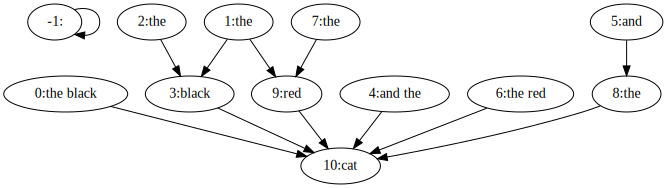

In [31]:
# get ready to visualize the decision tree in SVG
import graphviz
from IPython.display import SVG

# Source: https://github.com/interedition/collatex/blob/master/collatex-pythonport/collatex/display_module.py
# node id values must be strings for graphviz
a = graphviz.Digraph(format="svg")
for key,value in decision_graph['nodes'].items():
    a.node(str(key), label=str(key) + ':' + value['ngram'])
for key,values in decision_graph['edges']['outgoing'].items(): # values is list of integers
    for value in values:
        a.edge(str(key), str(value))
SVG(a.view())

# old stuff below